# Import Modules

In [36]:
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler
import contextily as ctx
from shapely.geometry import Point

# Plotting by country - aggregated
import plotly.express as px

# Set Variables

In [2]:
lucas_filepath = "../data/modelling/baseline_datasets/250627_lucas_2018_cleaned.csv"

# Load Data

In [4]:
df = pd.read_csv(lucas_filepath)

# Exploration

### OC and N

In [5]:
num_values = ['OC', 'N']
df[num_values].describe()

OC             N
count  15941.000000  15941.000000
mean      47.075403      3.153852
std       80.095452      3.705830
min        2.100000      0.200000
25%       13.200000      1.300000
50%       21.900000      2.000000
75%       42.800000      3.400000
max      582.900000     42.800000

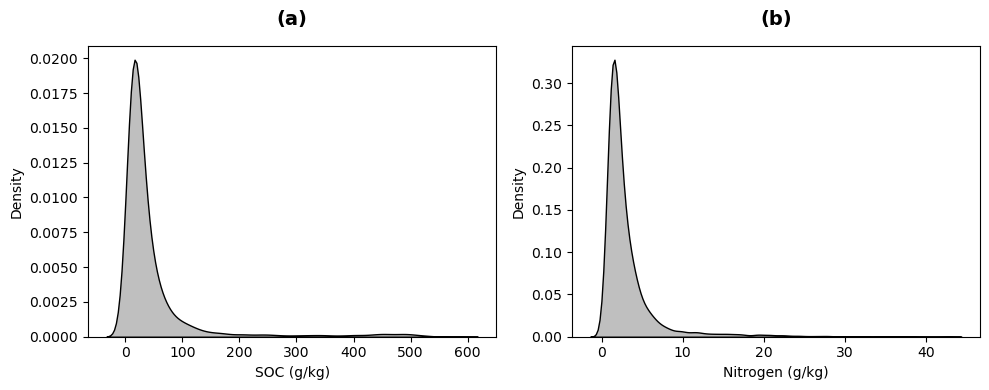

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes = axes.flatten()
title = {'OC': '(a)', 'N': '(b)'}
xlabel = {'OC': 'SOC', 'N': 'Nitrogen'}
for i, col in enumerate(num_values):
    sns.kdeplot(data=df, x=col, ax=axes[i], fill=True, color='black')

    axes[i].set_title(f'{title[col]}', fontweight='bold', fontsize=14, pad=15)
    axes[i].set_xlabel(f"{xlabel[col]} (g/kg)")
    axes[i].set_ylabel('Density')

plt.tight_layout()
plt.savefig('../graphs/soil/carbon_nitrogen_kde.png', dpi=300)
plt.show()

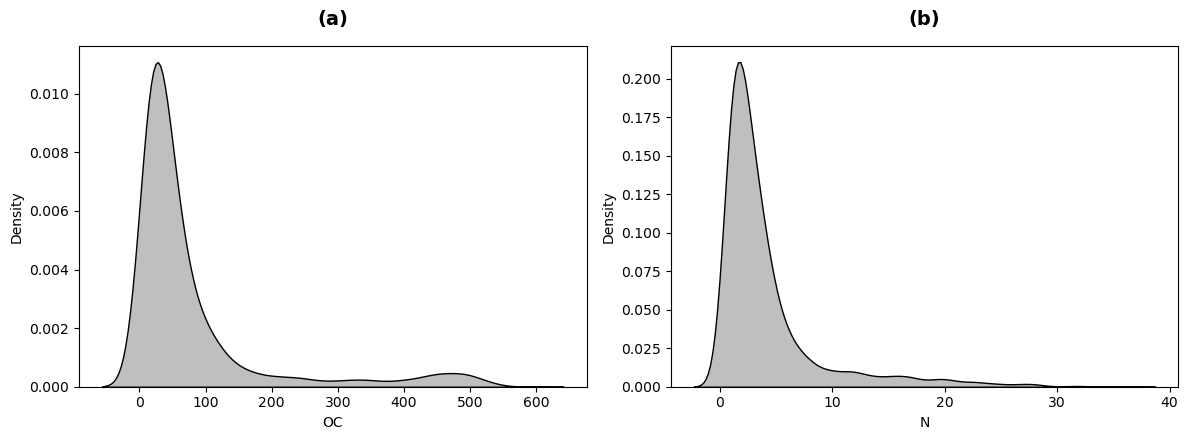

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(12,4.5))
plot_df = df[df['LU1_Desc'] != "Agriculture (excluding fallow land and kitchen gardens)"]
axes = axes.flatten()
title = {'OC': '(a)', 'N': '(b)'}
for i, col in enumerate(num_values):
    sns.kdeplot(data=plot_df, x=col, ax=axes[i], fill=True, color='black')

    axes[i].set_title(f'{title[col]}', fontweight='bold', fontsize=14, pad=15)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Density')
plt.savefig('../graphs/soil/carbon_nitrogen_kde_agriculture_only.png', dpi=300)
plt.tight_layout()
plt.show()

In [8]:
# Which land types have SOC values over 400
df[df['OC'] > 400]['LU1_Desc'].value_counts()

LU1_Desc
Forestry                                                   280
Semi-natural and natural areas not in use                   39
Agriculture (excluding fallow land and kitchen gardens)     22
Fallow land                                                  3
Name: count, dtype: int64

In [9]:
# Which land types have Nitrogen values over 30
df[df['N'] > 30]['LU1_Desc'].value_counts()

LU1_Desc
Forestry                                                   11
Agriculture (excluding fallow land and kitchen gardens)    10
Fallow land                                                 1
Name: count, dtype: int64

### What's happening at high values of OC and N

In [10]:
cat_features = df.select_dtypes('object').columns.tolist()

### Log Scale OC and N

In [11]:
df['log_OC'] = np.log1p(df['OC'])
df['log_N'] = np.log1p(df['N'])

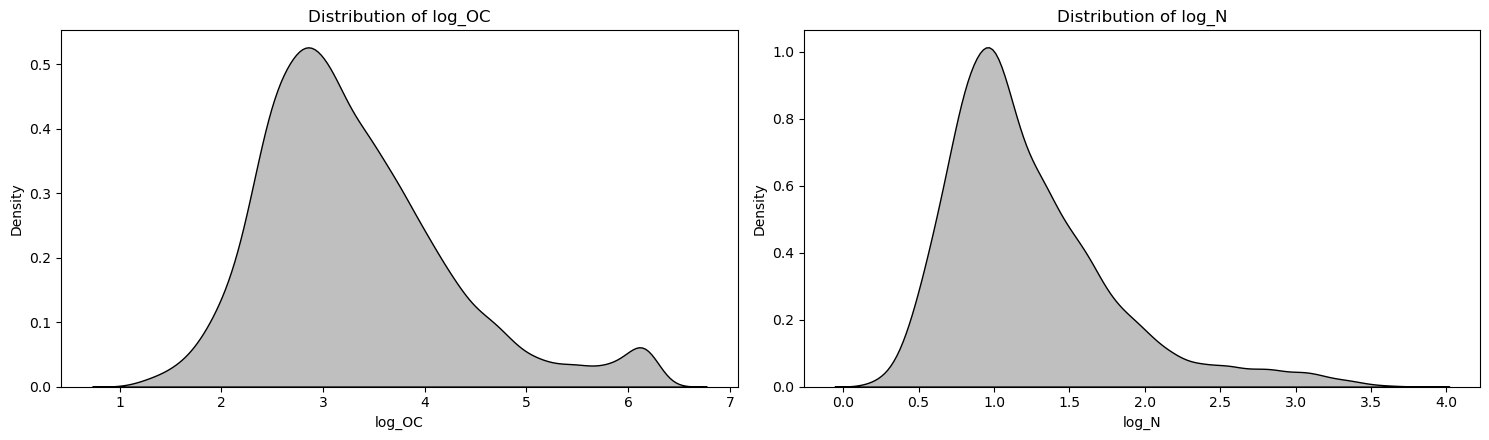

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(15,4.5))
axes = axes.flatten()

for i, col in enumerate(['log_OC', 'log_N']):
    sns.kdeplot(data=df, x=col, ax=axes[i], fill=True, color='black')
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Density')
plt.savefig('../graphs/soil/carbon_nitrogen_kde_logscaled.png', dpi=300)
plt.tight_layout()
plt.show()

In [14]:
df[['log_OC', 'log_N']].describe()

log_OC         log_N
count  15941.000000  15941.000000
mean       3.299024      1.226840
std        0.930850      0.552141
min        1.131402      0.182322
25%        2.653242      0.832909
50%        3.131137      1.098612
75%        3.779634      1.481605
max        6.369730      3.779634

### Correlation between Nitrogen and OC

In [15]:
# Min Max Scaler
scaler = MinMaxScaler()
df[['scaled_OC', 'scaled_N']] = scaler.fit_transform(df[['OC', 'N']])

In [16]:
plot_df = df.copy()
plot_df = plot_df.rename(columns={'LC0_Desc': 'Land cover',
                          'LU1_Desc': 'Land use'})
plot_df = plot_df.replace({'Agriculture (excluding fallow land and kitchen gardens)': 'Agriculture',
                           'Semi-natural and natural areas not in use': 'Natural areas not in use'})

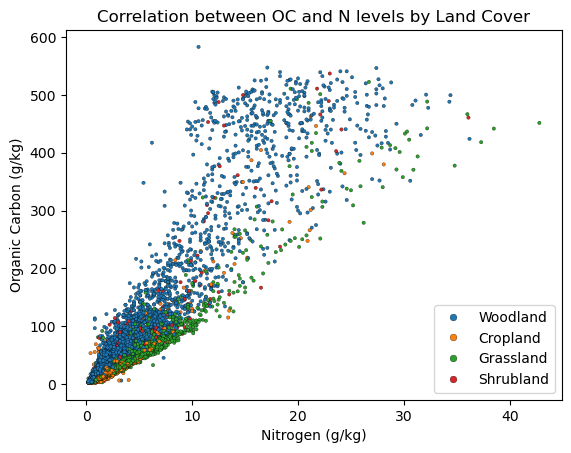

In [18]:
sns.scatterplot(plot_df, x='N', y='OC', color='lightgrey', edgecolor='black', hue='Land cover', s=6)
plt.xlabel('Nitrogen (g/kg)')
plt.ylabel('Organic Carbon (g/kg)')
plt.legend(markerscale=2)
plt.title("Correlation between OC and N levels by Land Cover")
plt.savefig('../graphs/soil/scatterplot_OCvN_byLandCover.png', dpi=300)
plt.show()

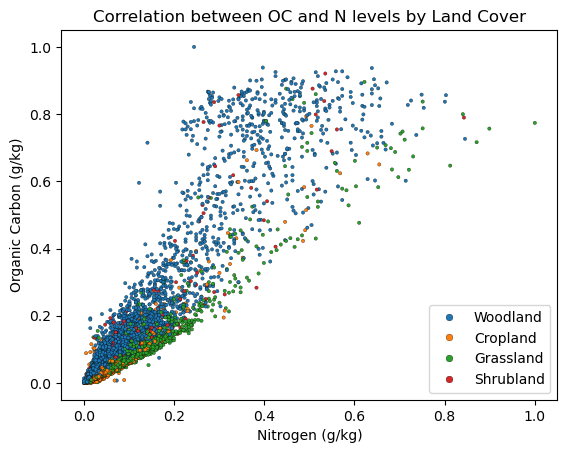

In [20]:
sns.scatterplot(plot_df, x='scaled_N', y='scaled_OC', color='lightgrey', edgecolor='black', hue='Land cover', s=6)
plt.xlabel('Nitrogen (g/kg)')
plt.ylabel('Organic Carbon (g/kg)')
plt.legend(markerscale=2)
plt.title("Correlation between OC and N levels by Land Cover")
plt.savefig('./graphs/soil/scatterplot_logOCvN_byLandCover.png', dpi=300)
plt.show()

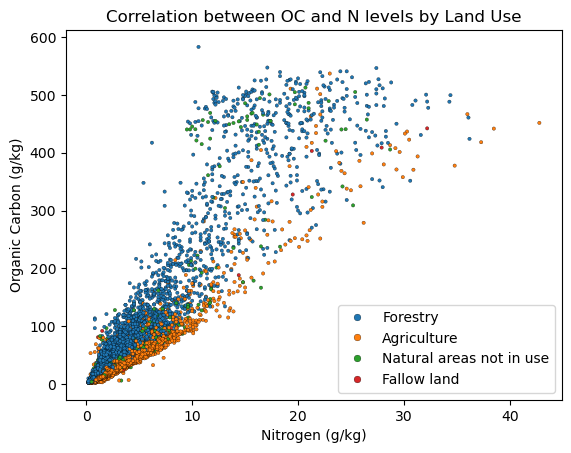

In [19]:
sns.scatterplot(plot_df, x='N', y='OC', color='lightgrey', edgecolor='black', hue='Land use', s=6)
plt.xlabel('Nitrogen (g/kg)')
plt.ylabel('Organic Carbon (g/kg)')
plt.legend(markerscale=2)
plt.title("Correlation between OC and N levels by Land Use")
plt.savefig('../graphs/soil/scatterplot_OCvN_byLandUse.png', dpi=300)
plt.show()

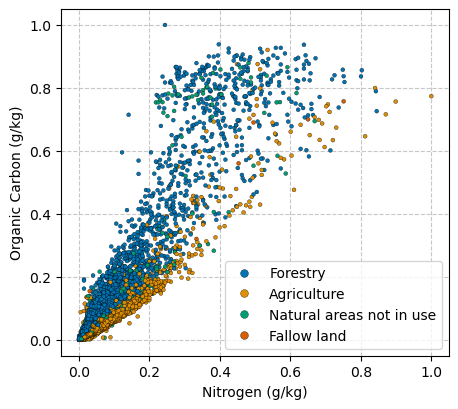

In [20]:
plt.figure(figsize=(5,4.5))
ax = sns.scatterplot(plot_df, x='scaled_N', y='scaled_OC', color='lightgrey', edgecolor='black', hue='Land use', s=8,
                    #  alpha=0.7,
                     palette="colorblind",)
plt.xlabel('Nitrogen (g/kg)')
plt.ylabel('Organic Carbon (g/kg)')
plt.legend(markerscale=2)
# plt.title("Correlation between OC and N levels by Land Use")
ax.set_axisbelow(True)
ax.grid(True, linestyle='--', alpha=0.7, axis='both')
plt.savefig('../graphs/soil/scatterplot_OCvN_byLandUse.png', dpi=300)
plt.show()

In [21]:
print(f"Number of samples with n value over 30: {len(df[df['N'] >= 30])}")
print(f"Number of samples with n value over 20: {len(df[df['N'] >= 20])}")
print(f"Number of samples with n value over 10: {len(df[df['N'] >= 10])}")

Number of samples with n value over 30: 22
Number of samples with n value over 20: 200
Number of samples with n value over 10: 765


In [22]:
# Look at other feature values for high values of Nitrogen
highest_n = df[df['N'] >= 20]
cat_features
for cat in cat_features:
    print(f"\n{cat}")
    print(highest_n[cat].value_counts())
    print()
    print("Original:")
    print(df[cat].value_counts())


SURVEY_DATE
SURVEY_DATE
2018-06-09    5
2018-05-30    5
2018-08-31    5
2018-04-07    4
2018-08-24    4
             ..
2018-08-27    1
2018-09-23    1
2018-11-06    1
2018-09-10    1
2018-07-30    1
Name: count, Length: 109, dtype: int64

Original:
SURVEY_DATE
2018-07-24    210
2018-12-07    198
2018-04-07    192
2018-10-07    185
2018-05-07    182
             ... 
2018-01-11      1
2018-04-11      1
2018-12-15      1
2018-03-31      1
2018-12-16      1
Name: count, Length: 257, dtype: int64

LC0_Desc
LC0_Desc
Woodland     142
Grassland     41
Cropland       9
Shrubland      8
Name: count, dtype: int64

Original:
LC0_Desc
Cropland     6671
Woodland     5161
Grassland    3502
Shrubland     607
Name: count, dtype: int64

LC1_Desc
LC1_Desc
Broadleaved woodland                      38
Spruce dominated mixed woodland           36
Grassland without tree/shrub cover        34
Pine dominated mixed woodland             23
Pine dominated coniferous woodland        15
Spruce dominated conifero

In [25]:
# Convert survey date to datetime format
df['SURVEY_DATE'] = pd.to_datetime(df['SURVEY_DATE'])

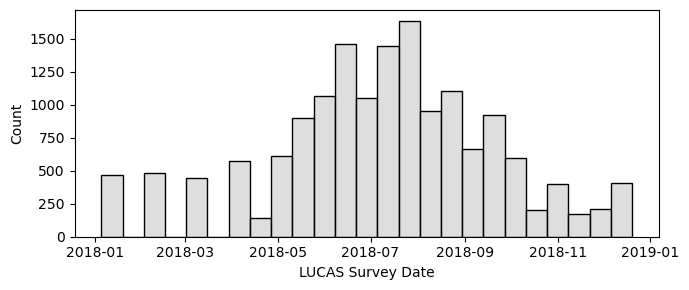

In [26]:
plt.figure(figsize=(7,3))
sns.histplot(df['SURVEY_DATE'], bins=25, color='lightgrey', edgecolor='black')
plt.xlabel("LUCAS Survey Date")
plt.tight_layout()
plt.savefig('../graphs/soil/histplot_surveydate.png', dpi=300)

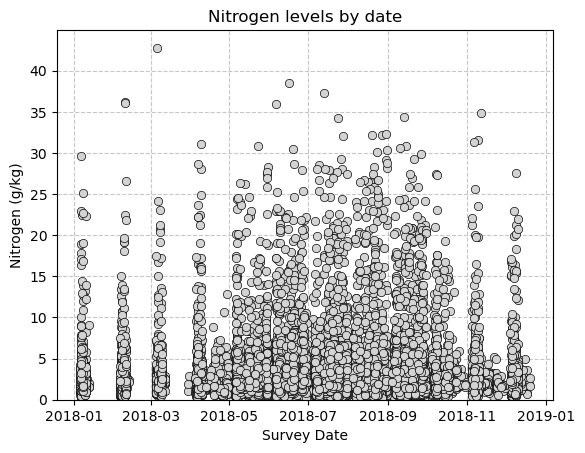

In [27]:
# Time of year and how that correlates with Nitrogen values
df['SURVEY_DATE'] = pd.to_datetime(df['SURVEY_DATE'])
ag_df = df[df['LU1_Desc'] == "Agriculture (excluding fallow land and kitchen gardens)"]
ax = sns.scatterplot(df, x='SURVEY_DATE', y='N', color='lightgrey', edgecolor='black')
ax.set_axisbelow(True)
ax.grid(True, linestyle='--', alpha=0.7, axis='both')
plt.xlabel("Survey Date")
plt.ylabel("Nitrogen (g/kg)")
plt.ylim(0,)
plt.title("Nitrogen levels by date")
plt.savefig("../graphs/soil/scatterplot_DateVN.png", dpi=300)
plt.show()

## Other Features

### Plot a correlation matrix of numerical features
Identify features which might have multicollinearity.

In [29]:
# Select numerical columns
num_df = df.select_dtypes(include='number').drop(columns=['POINTID'], errors='ignore')
num_df = num_df[['OC', 'N', 'Elev', 'gps_lat', 'gps_long', 'soil_stones_perc', 
            #    'log_OC', 'log_N', 'scaled_OC', 'scaled_N', 'lc1_perc',
            ]].rename(columns={'gps_long': 'Longitude',
                              'gps_lat': 'Latitude',
                              'soil_stones_perc': 'Soil Stones (%)',
                              'Elev': 'Elevation (m)'})

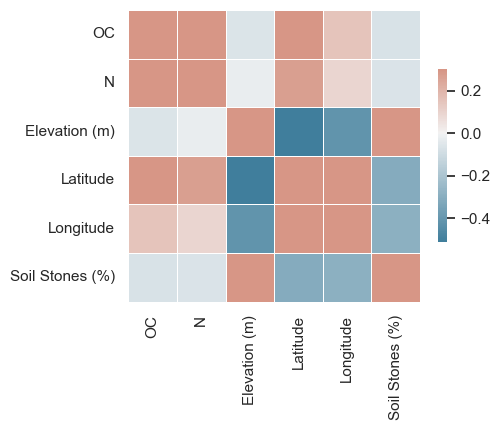

In [31]:
# Correlation matrix
sns.set_theme(style="white")

corr = num_df.corr()

# mask the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(5,5))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, 
            # mask=mask, 
            cmap=cmap, 
            vmax=.3, center=0,
            square=True, linewidth=.5, 
            cbar_kws={"shrink": .5})
plt.subplots_adjust(bottom=0.3)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('../graphs/soil/numerical_correlations.png', dpi=300)
plt.show()

## Visualise SOC and OC Values on a Heatmap

In [33]:
# Convert to geopandas dataframe
df['geometry'] = df.apply(lambda row: Point(row['gps_long'], row['gps_lat']), axis=1)
gdf = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326")

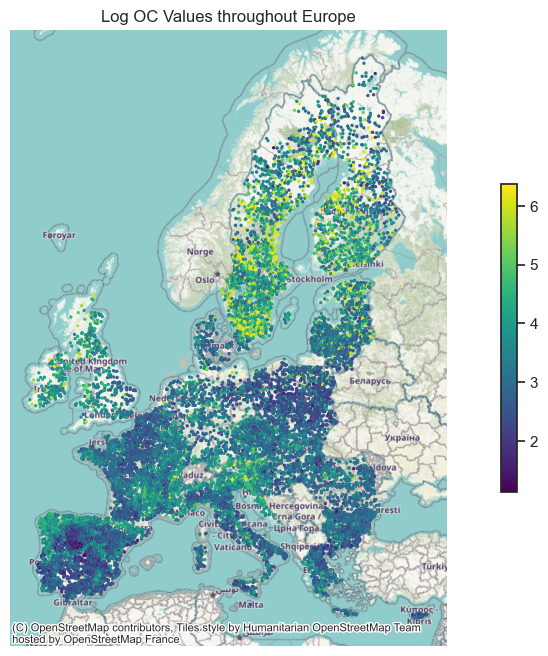

In [37]:
gdf = gdf.dropna(subset=['geometry'])

# Reproject for basemap
gdf_web = gdf.to_crs(epsg=3857)

# Plot - 
fig, ax = plt.subplots(figsize=(14, 8))
gdf_web.plot(column='log_OC', cmap='viridis', legend=False, markersize=2, ax=ax)
ctx.add_basemap(ax)
ax.set_title("Log OC Values throughout Europe")
ax.axis('off')
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=gdf['log_OC'].min(), vmax=gdf['log_OC'].max()))
sm._A = []  # empty array for compatibility
cbar = fig.colorbar(sm, ax=ax, shrink=0.5)  # try shrink=0.5, 0.6, etc.
plt.savefig('../graphs/soil/logOC_map_of_europe.png', dpi=300)
plt.show()

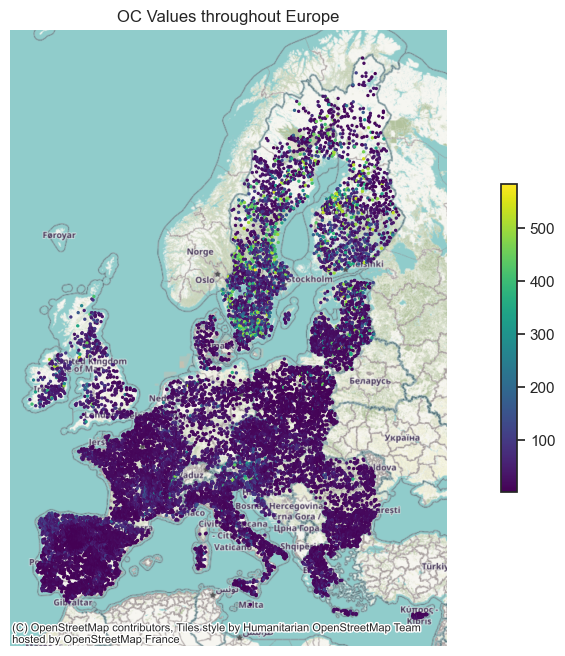

In [38]:
gdf = gdf.dropna(subset=['geometry'])

# Reproject for basemap
gdf_web = gdf.to_crs(epsg=3857)

# Plot - 
fig, ax = plt.subplots(figsize=(14, 8))
gdf_web.plot(column='OC', cmap='viridis', legend=False, markersize=2, ax=ax)
ctx.add_basemap(ax)
ax.set_title("OC Values throughout Europe")
ax.axis('off')
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=gdf['OC'].min(), vmax=gdf['OC'].max()))
sm._A = []  # empty array for compatibility
cbar = fig.colorbar(sm, ax=ax, shrink=0.5)  # try shrink=0.5, 0.6, etc.
plt.savefig('../graphs/soil/OC_map_of_europe.png', dpi=300)
plt.show()

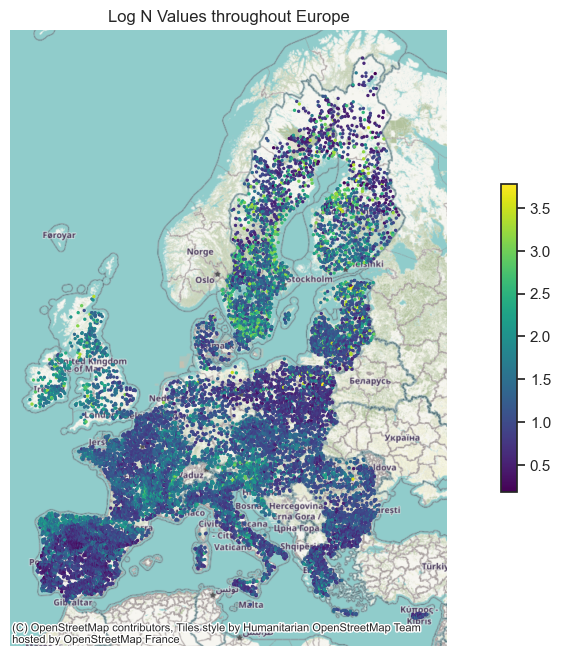

In [39]:
gdf = gdf.dropna(subset=['geometry'])

# Reproject for basemap
gdf_web = gdf.to_crs(epsg=3857)

# Plot - 
fig, ax = plt.subplots(figsize=(14, 8))
gdf_web.plot(column='log_N', cmap='viridis', legend=False, markersize=2, ax=ax)
ctx.add_basemap(ax)
ax.set_title("Log N Values throughout Europe")
ax.axis('off')
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=gdf['log_N'].min(), vmax=gdf['log_N'].max()))
sm._A = []  # empty array for compatibility
cbar = fig.colorbar(sm, ax=ax, shrink=0.5)  # try shrink=0.5, 0.6, etc.
plt.savefig('../graphs/soil/logN_map_of_europe.png', dpi=300)
plt.show()

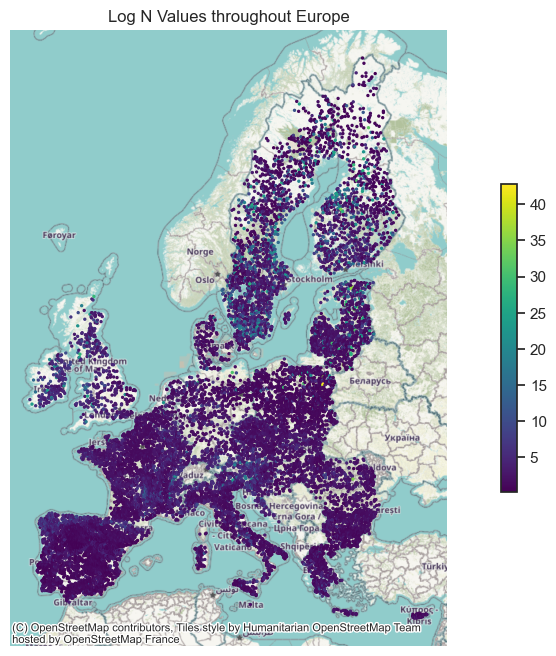

In [40]:
gdf = gdf.dropna(subset=['geometry'])

# Reproject for basemap
gdf_web = gdf.to_crs(epsg=3857)

# Plot - 
fig, ax = plt.subplots(figsize=(14, 8))
gdf_web.plot(column='N', cmap='viridis', legend=False, markersize=2, ax=ax)
ctx.add_basemap(ax)
ax.set_title("Log N Values throughout Europe")
ax.axis('off')
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=gdf['N'].min(), vmax=gdf['N'].max()))
sm._A = []  # empty array for compatibility
cbar = fig.colorbar(sm, ax=ax, shrink=0.5)  # try shrink=0.5, 0.6, etc.
plt.savefig('../graphs/soil/logN_map_of_europe.png', dpi=300)
plt.show()

## Elevation vs SOC and Nitrogen

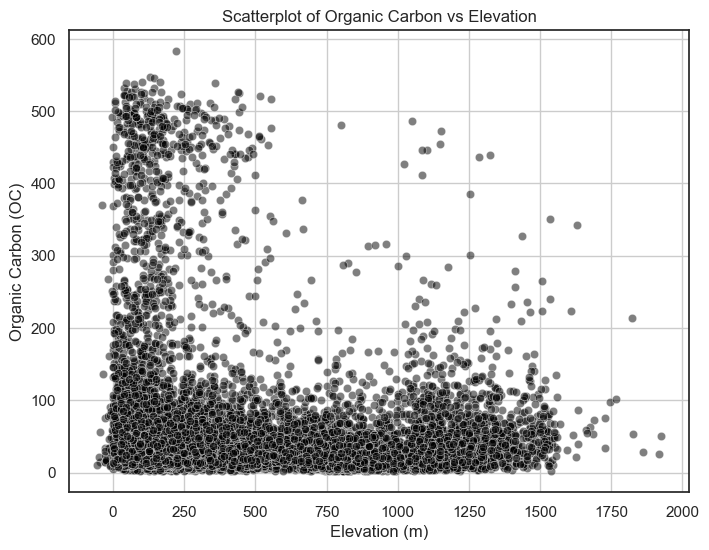

In [41]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='Elev', y='OC', alpha=0.5, color='black')
plt.title('Scatterplot of Organic Carbon vs Elevation')
plt.xlabel('Elevation (m)')
plt.ylabel('Organic Carbon (OC)')
plt.grid(True)
plt.savefig('../graphs/soil/scatterplot_carbon_elevation.png', dpi=300)
plt.show()

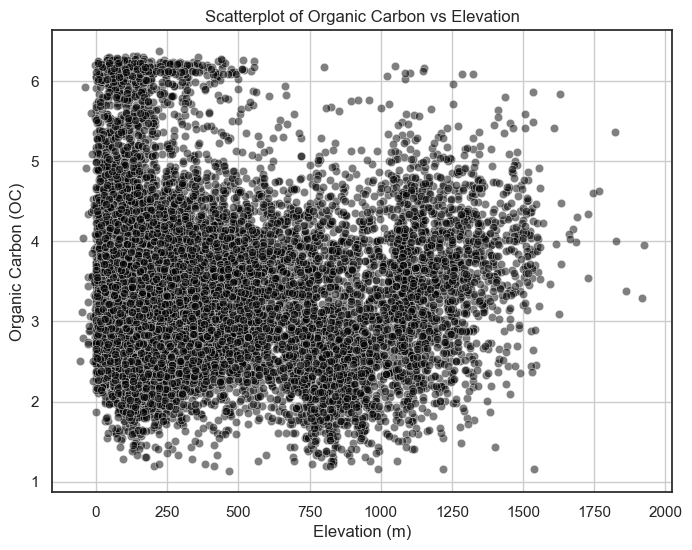

In [42]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='Elev', y='log_OC', alpha=0.5, color='black')
plt.title('Scatterplot of Organic Carbon vs Elevation')
plt.xlabel('Elevation (m)')
plt.ylabel('Organic Carbon (OC)')
plt.grid(True)
plt.savefig('../graphs/soil/scatterplot_log_carbon_elevation.png', dpi=300)
plt.show()

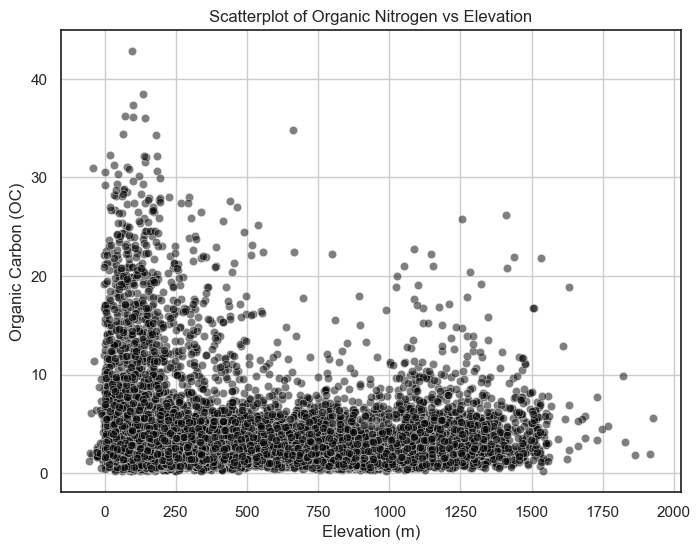

In [43]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='Elev', y='N', alpha=0.5, color='black')
plt.title('Scatterplot of Organic Nitrogen vs Elevation')
plt.xlabel('Elevation (m)')
plt.ylabel('Organic Carbon (OC)')
plt.grid(True)
plt.savefig('../graphs/soil/scatterplot_nitrogen_elevation.png', dpi=300)
plt.show()

## Land Cover Description: `LC0_Desc`

In [44]:
def plot_dual_axis_violin(df, category_col, figfile, column_name, title, rotation=90, figsize=(14, 6), xlabels=[]):
    """
    Plot Carbon and Nitrogen split violin plots with two shades of grey for thesis-ready export.
    
    Parameters:
    - df: DataFrame with log_OC_scaled and log_N_scaled columns
    - category_col: column to group by (e.g., 'LC1_Grouped')
    - figfile: file path to save the figure
    - column_name: label for the x-axis
    - rotation: x-axis tick label rotation
    - figsize: size of the figure
    """

    # Prepare long-form DataFrame
    df_long = df[[category_col, 'log_OC_scaled', 'log_N_scaled']].melt(
        id_vars=category_col,
        value_vars=['log_OC_scaled', 'log_N_scaled'],
        var_name='Feature',
        value_name='Scaled_Value'
    )

    df_long['Feature'] = df_long['Feature'].replace({
        'log_OC_scaled': 'Carbon',
        'log_N_scaled': 'Nitrogen'
    })

    # Use greyscale color palette
    grey_palette = {'Carbon': '#cccccc', 'Nitrogen': '#666666'}  # light grey vs dark grey

    # Plot
    plt.figure(figsize=figsize)
    sns.violinplot(data=df_long, x=category_col, y='Scaled_Value',
                   hue='Feature', split=True, 
                   inner='quart', #'box', 
                   palette=grey_palette,
                   edgecolor='black')

    plt.title(title)
    plt.xlabel(column_name)
    plt.ylabel('Min-Max Scaled Value')
    plt.xticks(rotation=rotation)
    # plt.legend(title='Feature')
    # Move legend outside
    plt.legend(
        title='Feature',
        loc='center left',
        bbox_to_anchor=(1.02, 0.5),
        borderaxespad=0
    )
    if len(xlabels) >0:
        plt.xticks(ticks=np.arange(len(xlabels)), labels=xlabels)
    # Reserve space on the right for the legend
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Add padding on the right

    plt.savefig(figfile, dpi=300)
    plt.show()


In [45]:
def plot_oc_by_category(
    df,
    column,            # The category column (e.g. 'LC1_Grouped')
    feature,           # 'log_OC_scaled' or 'log_N_scaled'
    figfile,           # File path to save the figure
    column_name,       # Label for the X-axis (e.g. 'Land Cover')
    rotation=90,       # Rotation for x-axis labels
    figsize=(8, 5),    # Figure size
    inner='box'
):
    # Set colour
    color = 'grey'
    
    # Create figure
    plt.figure(figsize=figsize)
    sns.violinplot(
        data=df,
        x=column,
        y=feature,
        inner=inner,
        color=color,
        edgecolor='black'
    )
    ylabel = {'log_N': "Log Nitrogen",
              'log_OC': 'Log Organic Carbon'}
    # Labels and styling
    plt.title(f'Spread of Log {"Carbon" if "oc" in feature.lower() else "Nitrogen"} by {column_name}')
    plt.xlabel(column_name)
    plt.ylabel(ylabel[feature])
    plt.xticks(rotation=rotation)

    plt.tight_layout()
    plt.savefig(figfile, dpi=300)
    plt.show()


In [46]:
scaler = MinMaxScaler()
df[['log_OC_scaled', 'log_N_scaled']] = scaler.fit_transform(df[['log_OC', 'log_N']])

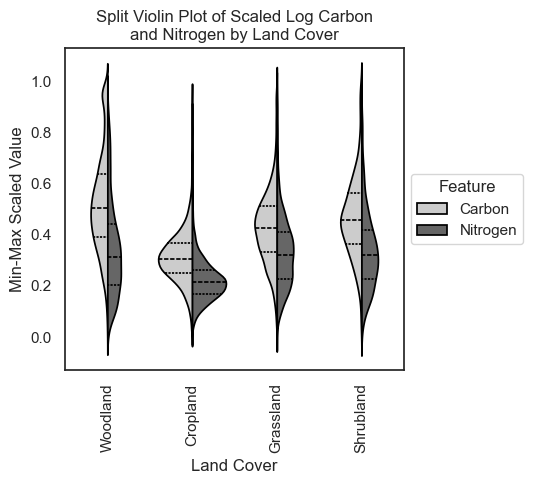

In [47]:
column = 'LC0_Desc'
column_name = 'Land Cover'
violin=True
figsize = (6.5, 5)
title = f'Split Violin Plot of Scaled Log Carbon\nand Nitrogen by {column_name}'
figfile = f'./graphs/soil/violinplot_{column}_dual.png'

plot_dual_axis_violin(df, column, figfile=figfile, column_name=column_name, title=title, figsize=figsize)

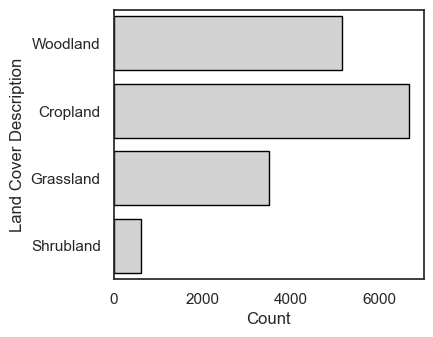

In [76]:
plt.figure(figsize=(4,3.5))
sns.countplot(df['LC0_Desc'], color='lightgrey', edgecolor='black')
plt.xlabel("Count")
plt.ylabel("Land Cover Description")
plt.show()

## Land Cover - `LC1_Desc`

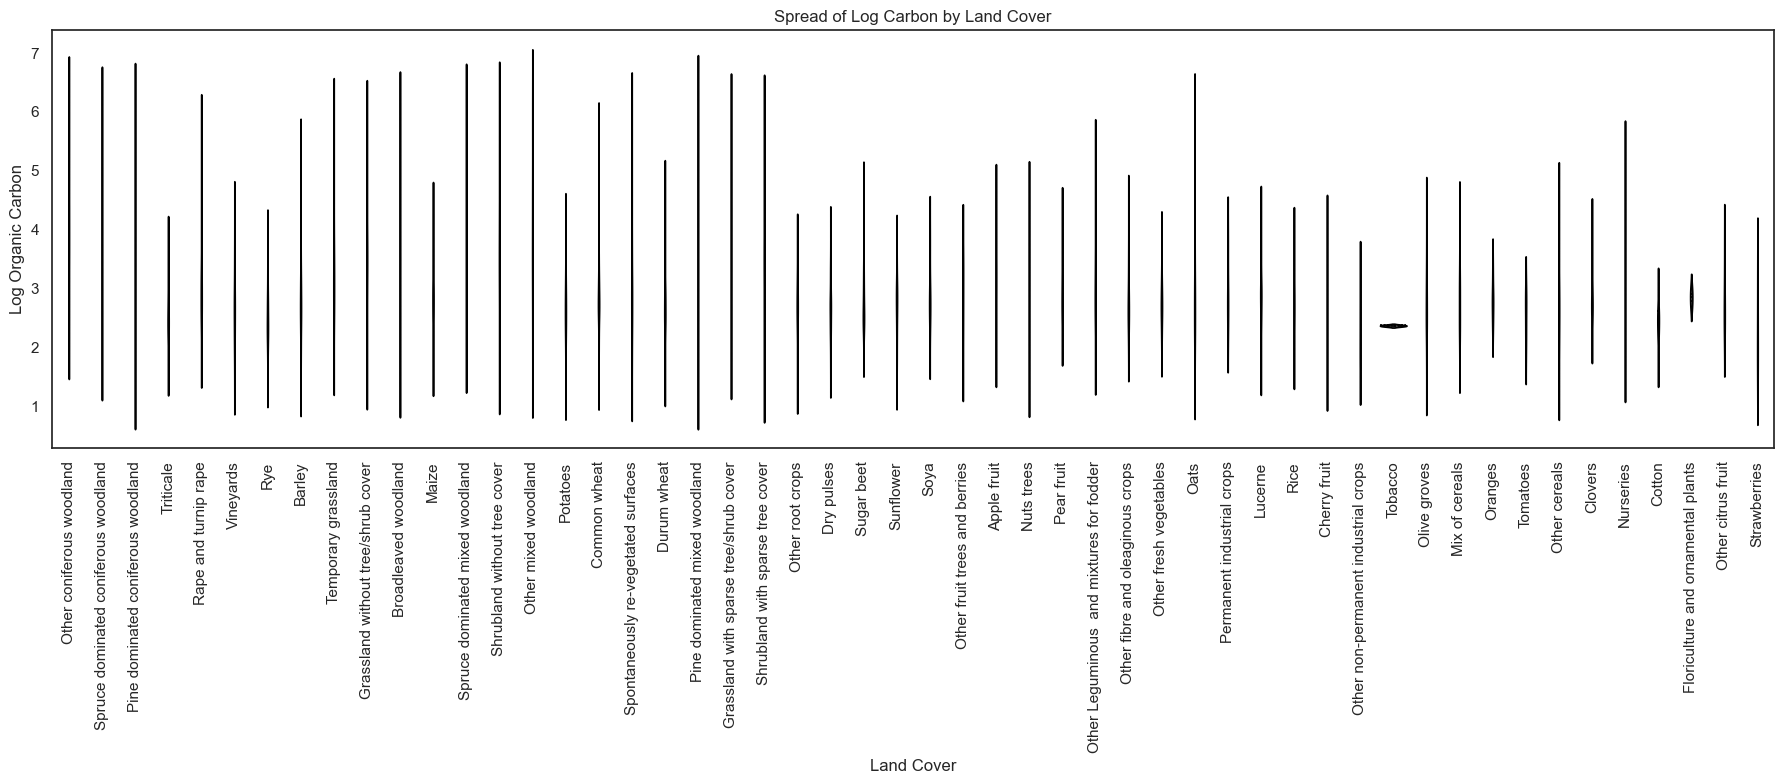

In [48]:
feature = 'log_OC'
column = 'LC1_Desc'
column_name = "Land Cover"
violin=True
figsize = (18, 8)
inner = 'quart'
figfile = f'./graphs/soil/violinplot_{column}_{feature}.png'

plot_oc_by_category(df, column, feature, figfile, column_name, figsize=figsize, inner=inner)


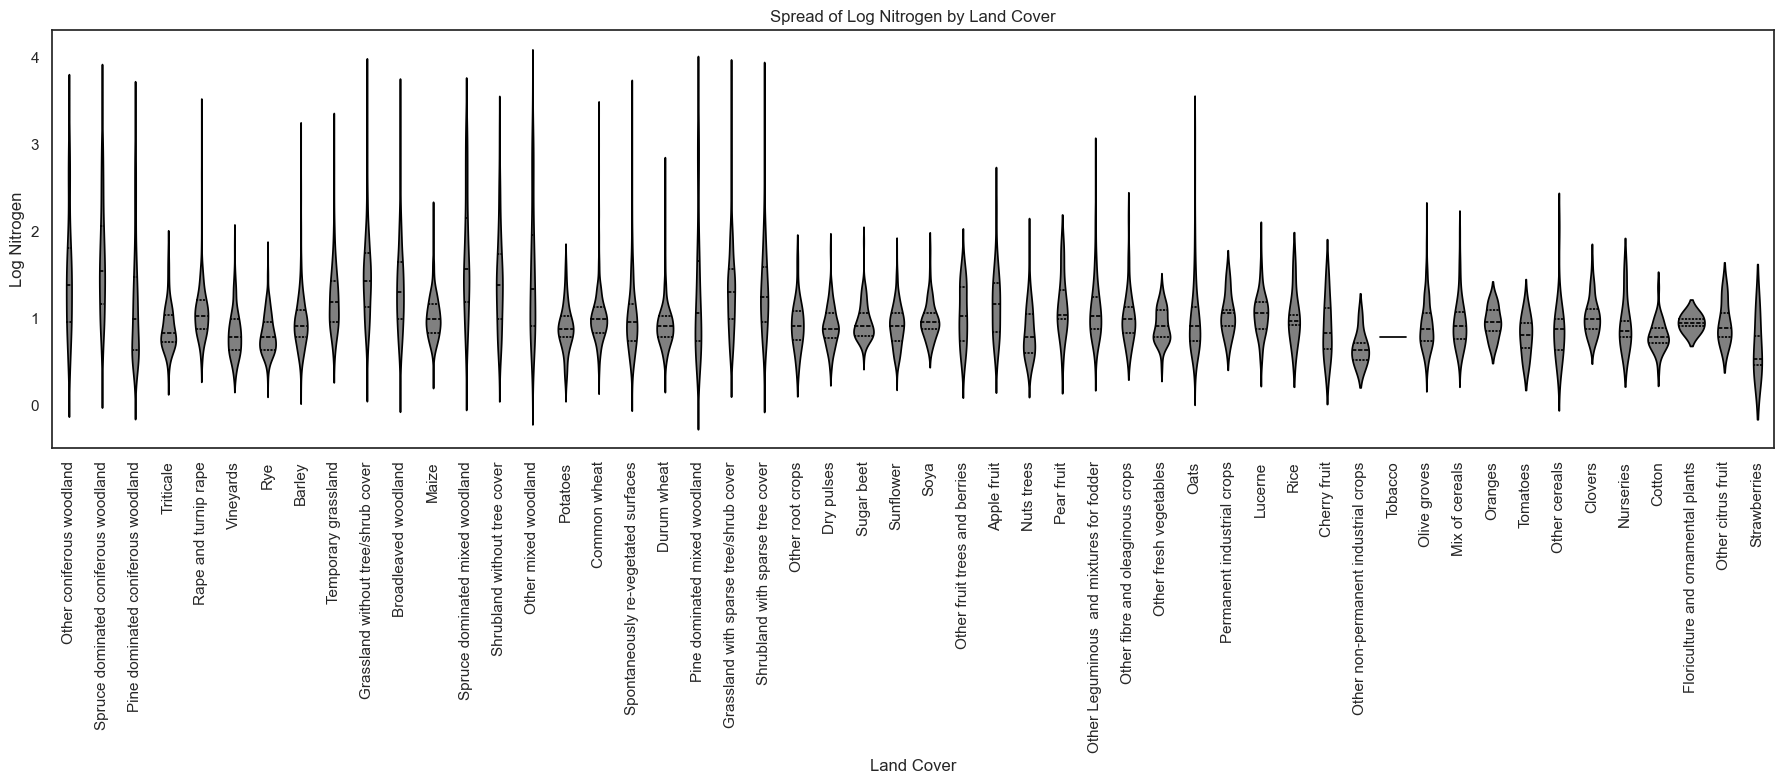

In [49]:
feature = 'log_N'
column = 'LC1_Desc'
column_name = "Land Cover"
violin=True
figsize = (18, 8)
inner = 'quart'
figfile = f'./graphs/soil/violinplot_{column}_{feature}.png'

plot_oc_by_category(df, column, feature, figfile, column_name, figsize=figsize, inner=inner)

## Group Categories for Crop Type

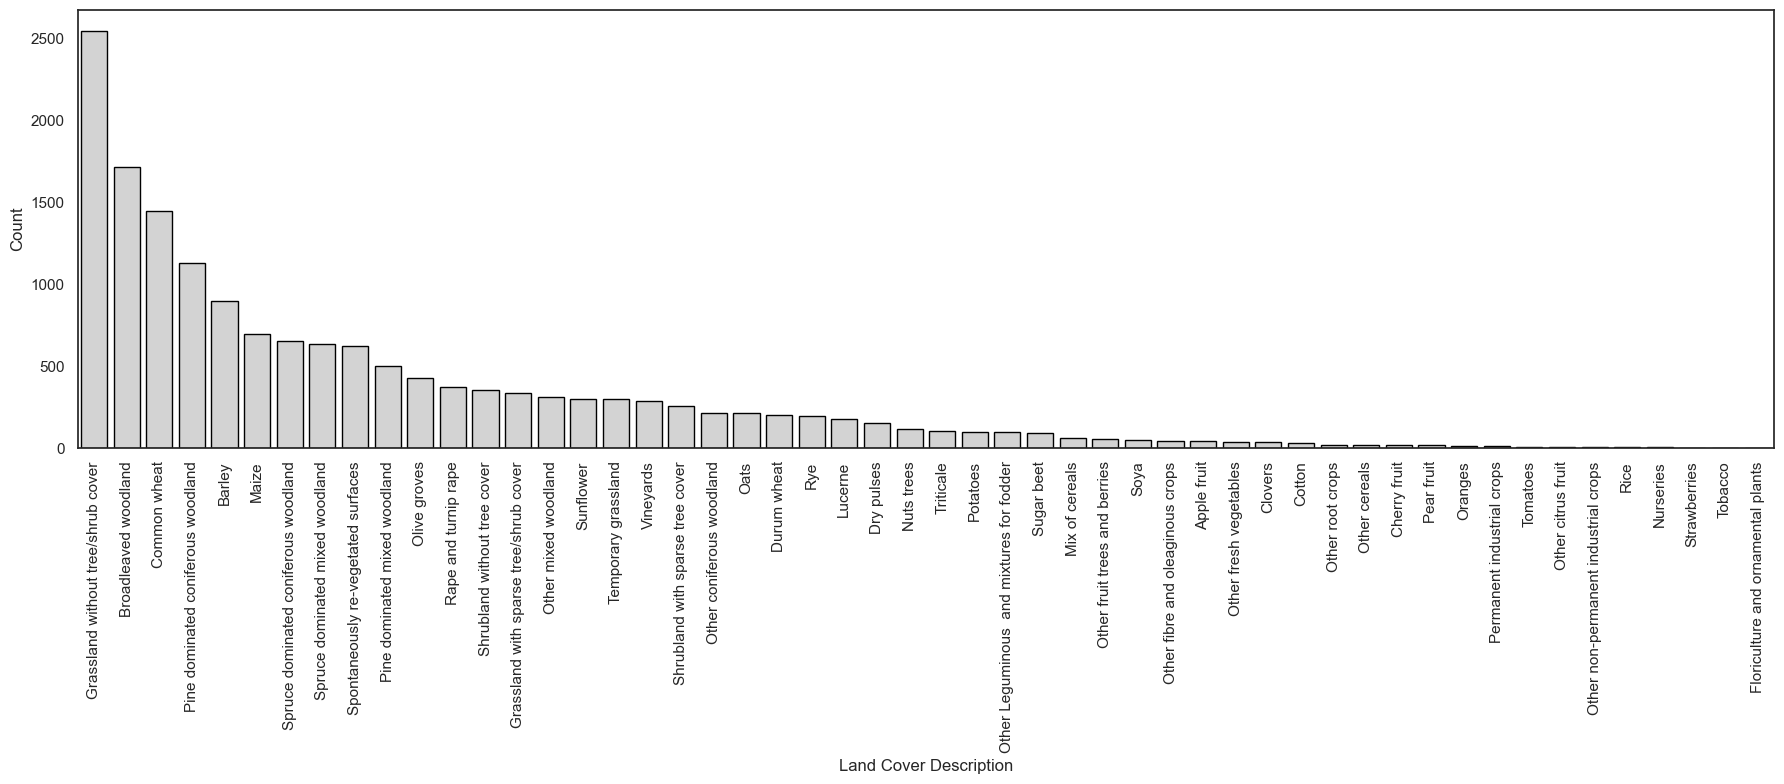

In [50]:
plt.figure(figsize=(18, 8))
sns.countplot(df, x='LC1_Desc', color='lightgrey', edgecolor='black', order=df['LC1_Desc'].value_counts().index)
plt.ylabel("Count")
plt.xlabel("Land Cover Description")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("./graphs/soil/LC1_Desc_countplot.png")
plt.show()

In [51]:
# Define mapping of group names to sets of original category names
lc1_group_map = {
    'Woodland/Shrubland': {
        'Broadleaved woodland', 'Pine dominated coniferous woodland',
        'Spruce dominated coniferous woodland', 'Spruce dominated mixed woodland',
        'Pine dominated mixed woodland', 'Other coniferous woodland',
        'Other mixed woodland', 'Shrubland without tree cover',
        'Shrubland with sparse tree cover', 'Grassland with sparse tree/shrub cover'
    },
    'Grassland': {
        'Grassland without tree/shrub cover', 'Temporary grassland'
    },
    'Cereals': {
        'Common wheat', 'Barley', 'Maize', 'Rye', 'Triticale',
        'Durum wheat', 'Oats', 'Rice', 'Mix of cereals', 'Other cereals'
    },
    'Root Crops': {
        'Potatoes', 'Sugar beet', 'Other root crops'
    },
    'Oilseeds & Pulses': {
        'Rape and turnip rape', 'Dry pulses', 'Sunflower', 'Soya',
        'Other fibre and oleaginous crops'
    },
    'Fruits & Nuts': {
        'Vineyards', 'Cherry fruit', 'Pear fruit', 'Apple fruit',
        'Other fruit trees and berries', 'Nuts trees', 'Oranges',
        'Other citrus fruit', 'Strawberries'
    },
    'Vegetables & Fodder': {
        'Tomatoes', 'Other fresh vegetables', 'Lucerne', 'Clovers',
        'Other Leguminous and mixtures for fodder'
    },
    'Industrial Crops': {
        'Cotton', 'Tobacco', 'Permanent industrial crops',
        'Other non-permanent industrial crops'
    },
    'Sparsely Vegetated/Natural': {
        'Spontaneously re-vegetated surfaces', 'Nurseries',
        'Floriculture and ornamental plants'
    },
    'Tree Crops': {
        'Olive groves'
    }
}


# Create a reverse lookup dictionary: {category: group}
category_to_group = {cat: group for group, cats in lc1_group_map.items() for cat in cats}

# Apply mapping with fallback to 'Other'
df['LC1_Grouped'] = df['LC1_Desc'].map(category_to_group).fillna('Other')

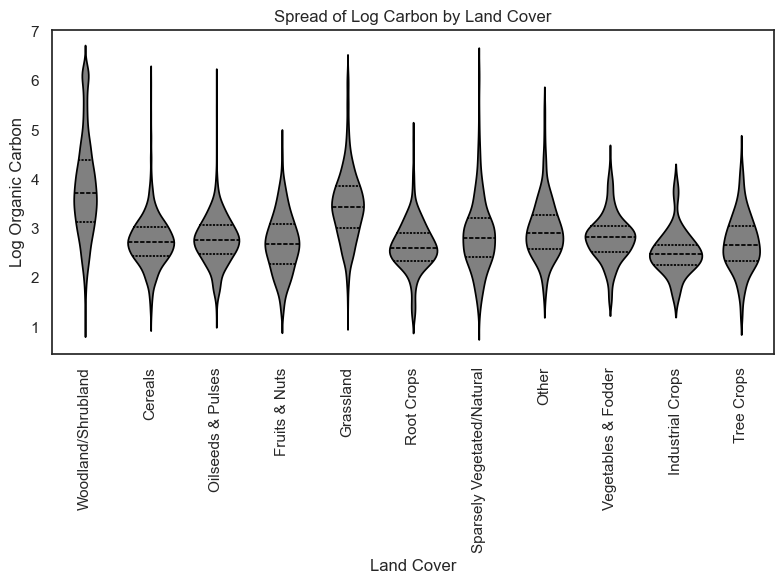

In [52]:
feature = 'log_OC'
column = 'LC1_Grouped'
column_name = "Land Cover"
violin=True
figsize = (8, 6)
inner = 'quart'
figfile = f'./graphs/soil/violinplot_{column}_{feature}.png'

plot_oc_by_category(df, column, feature, figfile, column_name, figsize=figsize, inner=inner)

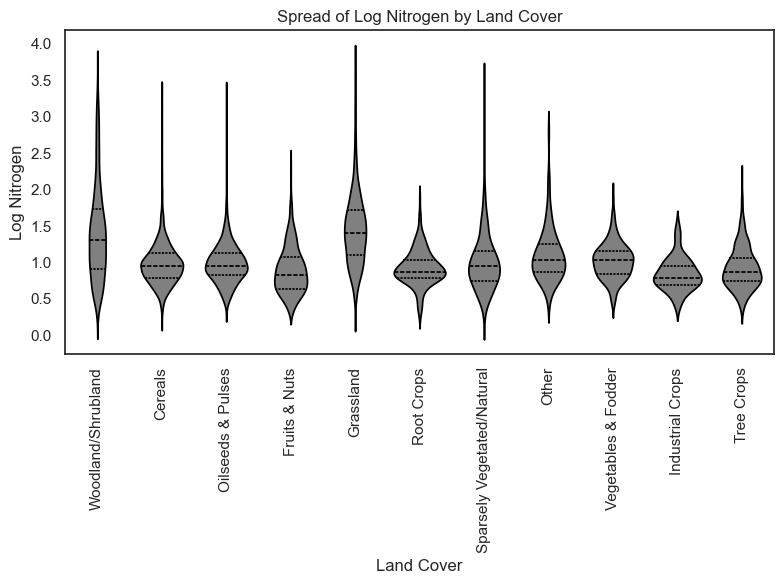

In [53]:
feature = 'log_N'
column = 'LC1_Grouped'
column_name = "Land Cover"
violin=True
figsize = (8, 6)
inner = 'quart'
figfile = f'./graphs/soil/violinplot_{column}_{feature}.png'

plot_oc_by_category(df, column, feature, figfile, column_name, figsize=figsize, inner=inner)

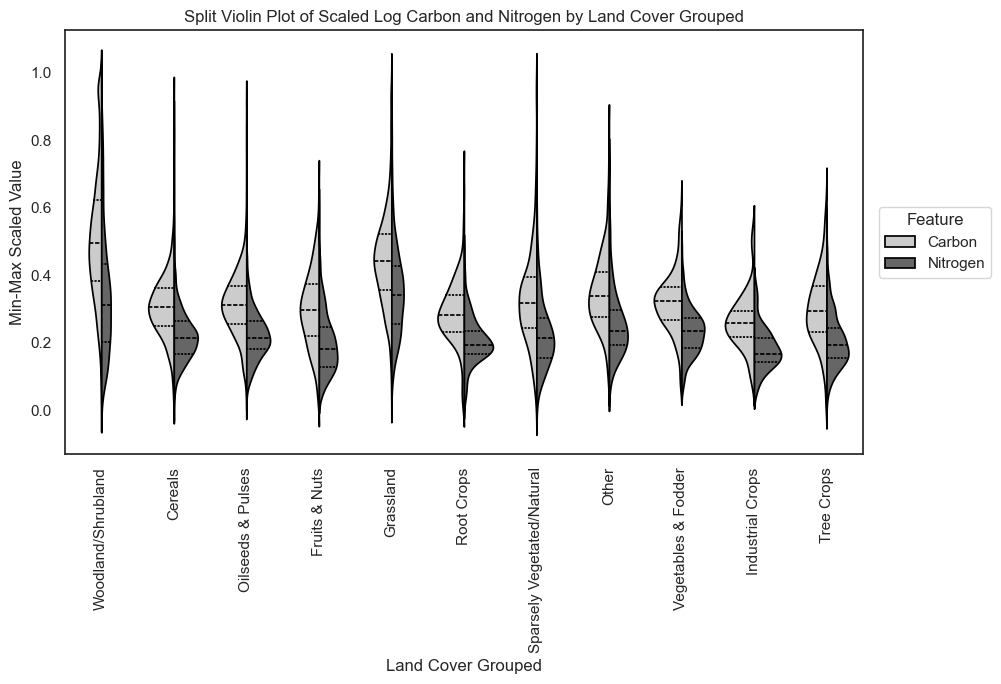

In [54]:
column = 'LC1_Grouped'
column_name = 'Land Cover Grouped'
violin=True
figsize = (12, 7)
title = f'Split Violin Plot of Scaled Log Carbon and Nitrogen by {column_name}'
figfile = f'./graphs/soil/violinplot_{column}_dual.png'

plot_dual_axis_violin(df, column, figfile=figfile, column_name=column_name, title=title, figsize=figsize)

In [55]:
df = df.drop(columns=['LC1_Desc'], errors='ignore')

## Land Use Description - `LU1_Desc`

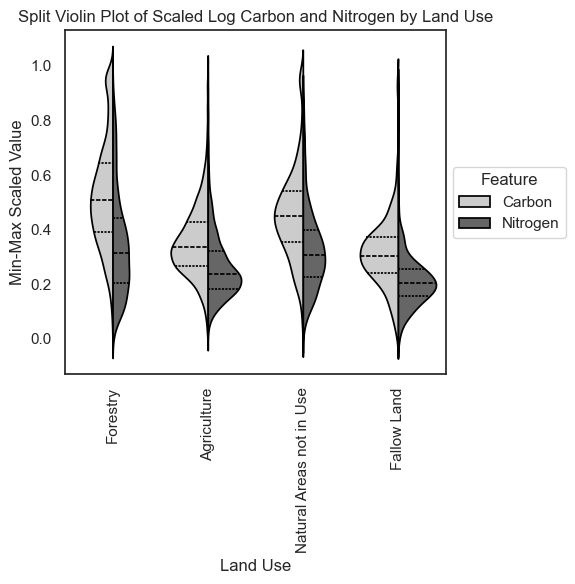

In [56]:
column = 'LU1_Desc'
column_name = 'Land Use'
violin=True
figsize = (7,6)
title = f'Split Violin Plot of Scaled Log Carbon and Nitrogen by {column_name}'
figfile = f'./graphs/soil/violinplot_{column}_dual.png'
xlabels = ['Forestry', 'Agriculture', 'Natural Areas not in Use', 'Fallow Land']

plot_dual_axis_violin(df, column, figfile=figfile, column_name=column_name, title=title, figsize=figsize, xlabels=xlabels)

## Elevation 

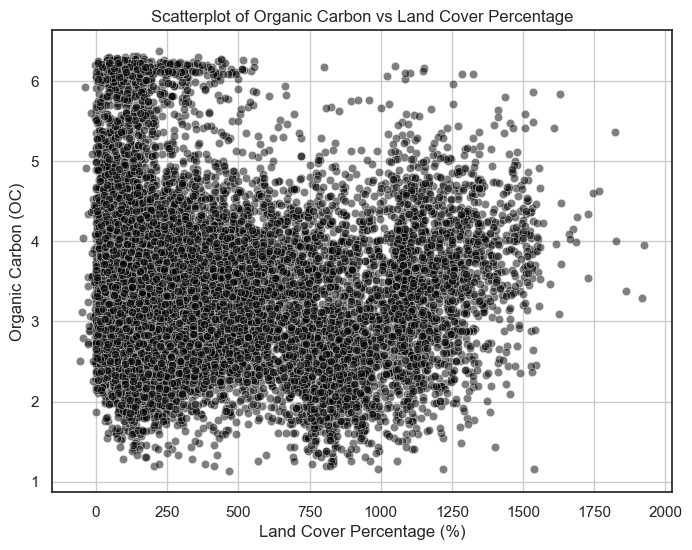

In [63]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='Elev', y='log_OC', alpha=0.5, color='black')
plt.title('Scatterplot of Organic Carbon vs Land Cover Percentage')
plt.xlabel('Land Cover Percentage (%)')
plt.ylabel('Organic Carbon (OC)')
plt.grid(True)
plt.savefig('./graphs/soil/scatterplot_soc_elev.png', dpi=300)
plt.show()

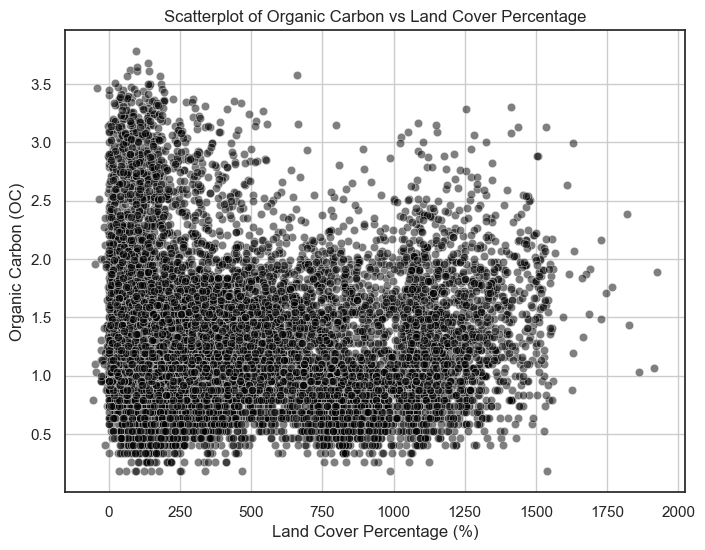

In [64]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='Elev', y='log_N', alpha=0.5, color='black')
plt.title('Scatterplot of Organic Carbon vs Land Cover Percentage')
plt.xlabel('Land Cover Percentage (%)')
plt.ylabel('Organic Carbon (OC)')
plt.grid(True)
plt.savefig('./graphs/soil/scatterplot_nitrogen_elev.png', dpi=300)
plt.show()

## Parcel Area Ha

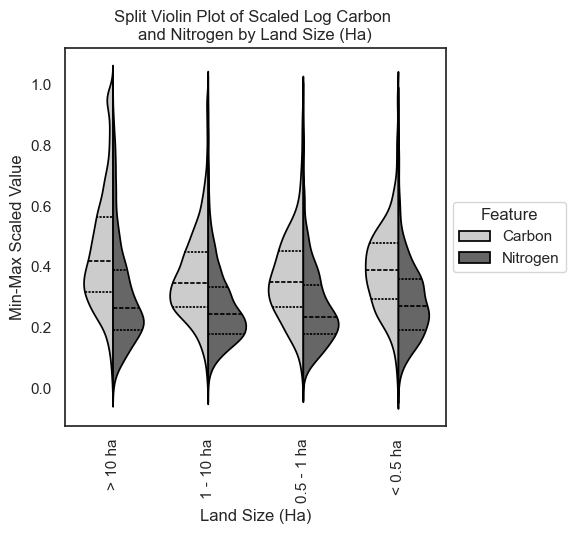

In [65]:
column = 'parcel_area_ha'
column_name = 'Land Size (Ha)'
violin=True
figsize = (7, 5.5)
title = f'Split Violin Plot of Scaled Log Carbon \nand Nitrogen by {column_name}'
figfile = f'./graphs/soil/violinplot_{column}_dual.png'

plot_dual_axis_violin(df, column, figfile=figfile, column_name=column_name, title=title, figsize=figsize)

## Crop Residues

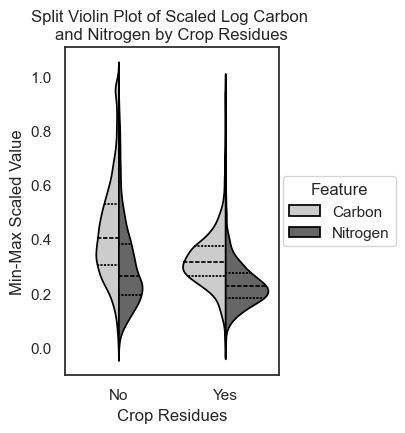

In [66]:
column = 'crop_residues'
column_name = 'Crop Residues'
violin=True
figsize = (5, 4.5)
title = f'Split Violin Plot of Scaled Log Carbon \nand Nitrogen by {column_name}'
figfile = f'./graphs/soil/violinplot_{column}_dual.png'

plot_dual_axis_violin(df, column, figfile=figfile, column_name=column_name, title=title, figsize=figsize, rotation=0)

## Grass Margins

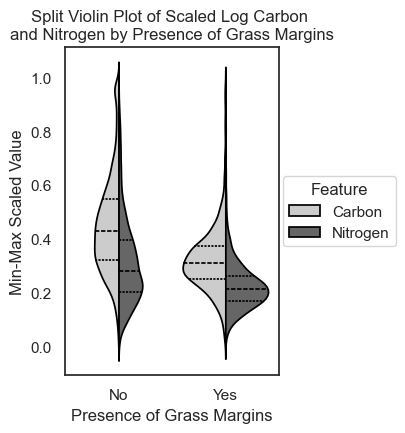

In [67]:
column = 'lm_grass_margins'
column_name = 'Presence of Grass Margins'
violin=True
figsize = (5, 4.5)
title = f'Split Violin Plot of Scaled Log Carbon \nand Nitrogen by {column_name}'
figfile = f'./graphs/soil/violinplot_{column}_dual.png'

plot_dual_axis_violin(df, column, figfile=figfile, column_name=column_name, title=title, figsize=figsize, rotation=0)

## Grazing

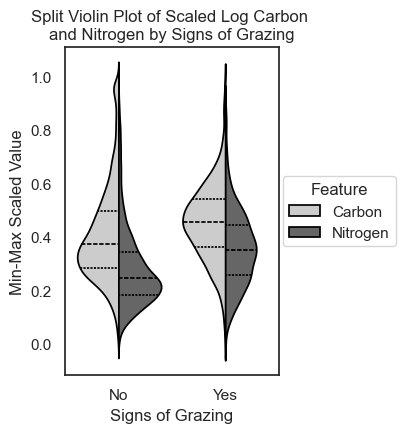

In [68]:
column = 'grazing'
column_name = 'Signs of Grazing'
violin=True
figsize = (5, 4.5)
title = f'Split Violin Plot of Scaled Log Carbon \nand Nitrogen by {column_name}'
figfile = f'./graphs/soil/violinplot_{column}_dual.png'
df['grazing'] = df['grazing'].replace({'No signs of grazing': 'No', 'Signs of grazing': 'Yes'})

plot_dual_axis_violin(df, column, figfile=figfile, column_name=column_name, title=title, figsize=figsize, rotation=0)

## Country

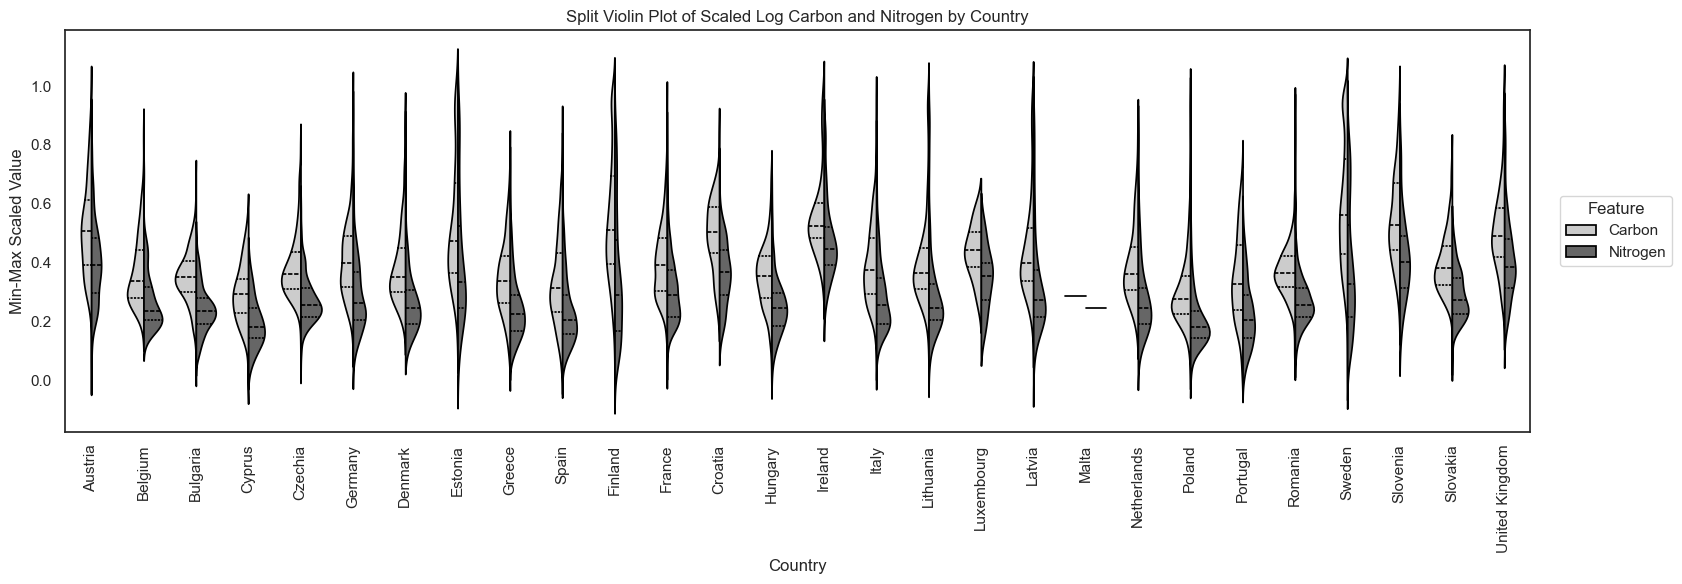

In [69]:
column = 'country_name'
column_name = 'Country'
violin=True
figsize = (20, 6)
title = f'Split Violin Plot of Scaled Log Carbon and Nitrogen by {column_name}'
figfile = f'./graphs/soil/violinplot_{column}_dual.png'
df['grazing'] = df['grazing'].replace({'No signs of grazing': 'No', 'Signs of grazing': 'Yes'})

plot_dual_axis_violin(df, column, figfile=figfile, column_name=column_name, title=title, figsize=figsize)

## Survey Points over time

In [70]:
df['SURVEY_DATE'] = pd.to_datetime(df['SURVEY_DATE'])

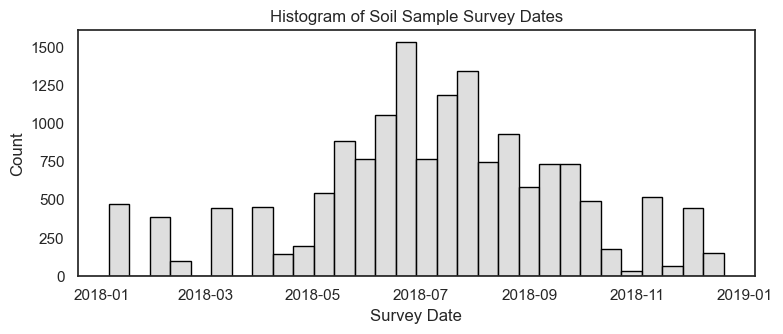

In [71]:
plt.figure(figsize=(8,3.5))
sns.histplot(df['SURVEY_DATE'], color='lightgrey', edgecolor='black', bins=30)
plt.xlabel('Survey Date')
plt.title('Histogram of Soil Sample Survey Dates')
plt.tight_layout()
plt.savefig('./graphs/soil/histplot_survey_date.png', dpi=300)
plt.show()

## Nitrogen and Carbon Levels over Time

/opt/miniconda3/envs/thesis_test/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


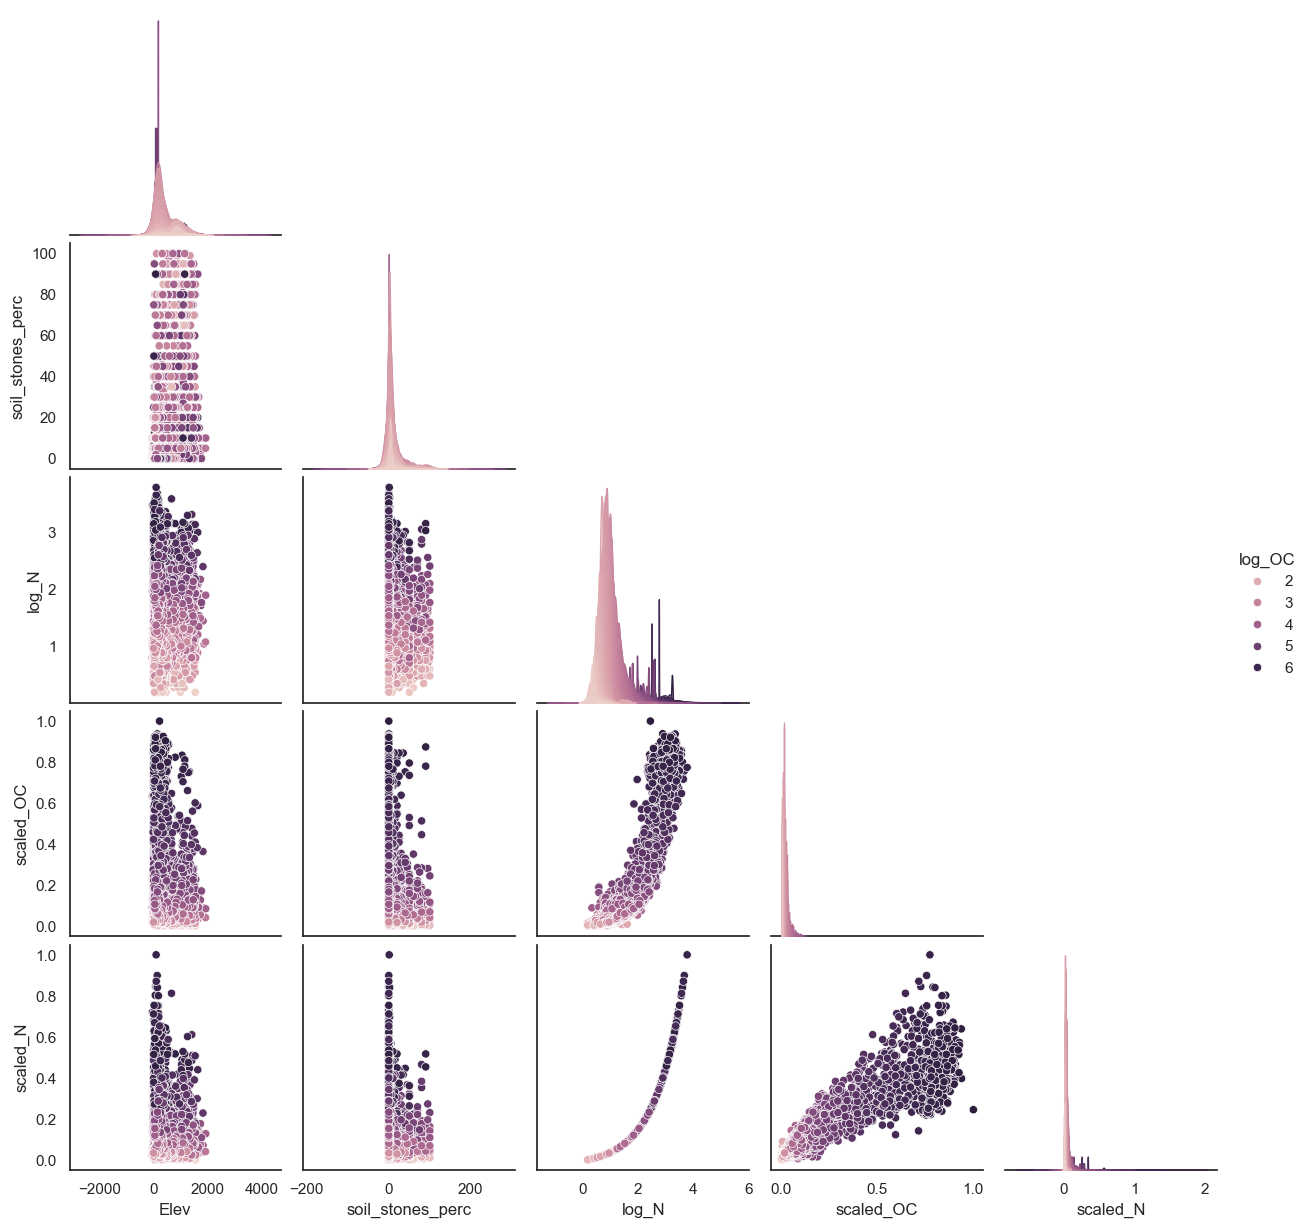

In [72]:
num_df = df[df.select_dtypes(include=np.number).columns.tolist()].drop(columns=['POINTID', 'OC', 'N', 'gps_long', 'gps_lat', 'log_OC_scaled', 'log_N_scaled'])
sns.pairplot(num_df, hue='log_OC', corner=True)

/opt/miniconda3/envs/thesis_test/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


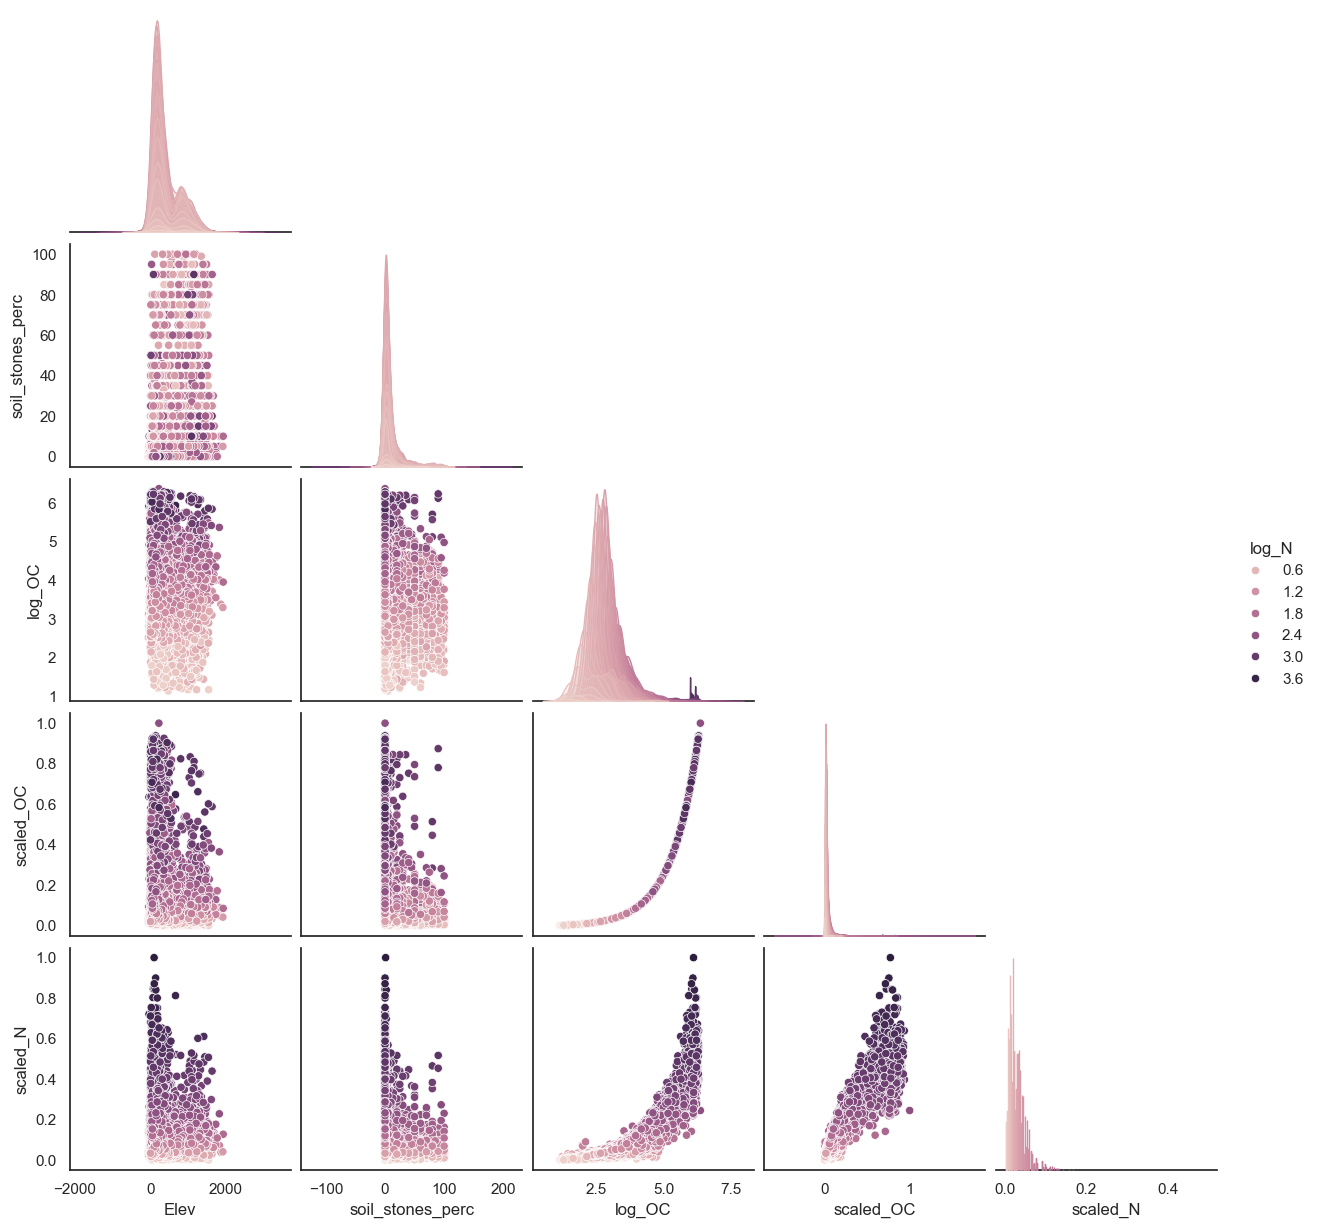

In [73]:
sns.pairplot(num_df, hue='log_N', corner=True)

# Save to CSV

In [168]:
df.to_csv("./data/modelling/baseline_datasets/processed/20250711_lucas_cleaned.csv", index=False)

# Load CSV

In [3]:
df = pd.read_csv("./data/modelling/baseline_datasets/processed/20250711_lucas_cleaned.csv")